# Goal: spatial auto-correlation of 2 channels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imsave
from scipy import signal
from scipy import misc
import scipy.fftpack
from scipy import stats
from skimage import io
from skimage.filters import threshold_otsu, threshold_local
import os


### read images

In [3]:
path=***** please add path to the image directory *****


parent=os.path.split(os.path.split(path)[0])[0]

files=[]
tmp=os.listdir(path)
for f in tmp:
    if (".tif" in f)==True:  
        if ("." in f)==True: 
            files=files+[f]
files

['selected_PFA_C3-3A_mut_01.tif',
 'selected_PFA_C3-3A_mut_02.tif',
 'selected_PFA_C3-3A_mut_03.tif',
 'selected_PFA_C3-3A_mut_05.tif',
 'selected_PFA_C3-3A_mut_09.tif',
 'selected_PFA_C3-3A_mut_10.tif',
 'selected_PFA_C3-3A_mut_11.tif',
 'selected_PFA_C3-3A_mut_12.tif',
 'selected_PFA_C3-3A_mut_14.tif',
 'selected_PFA_C3-3A_mut_15.tif',
 'selected_PFA_C3-3A_mut_16.tif',
 'selected_PFA_C3-3A_mut_19.tif',
 'selected_PFA_C3-3A_mut_20.tif',
 'selected_PFA_C3-3A_mut_24.tif',
 'selected_PFA_C3-3A_mut_26.tif',
 'selected_PFA_C3-3A_mut_28.tif',
 'selected_PFA_C3-3A_wt_01.tif',
 'selected_PFA_C3-3A_wt_02.tif',
 'selected_PFA_C3-3A_wt_03.tif',
 'selected_PFA_C3-3A_wt_04.tif',
 'selected_PFA_C3-3A_wt_05.tif',
 'selected_PFA_C3-3A_wt_08.tif',
 'selected_PFA_C3-3A_wt_12.tif',
 'selected_PFA_C3-3A_wt_13.tif',
 'selected_PFA_C3-3A_wt_14.tif',
 'selected_PFA_C3-3A_wt_16.tif',
 'selected_PFA_C3-3A_wt_17.tif',
 'selected_PFA_C3-3A_wt_18.tif',
 'selected_PFA_C3-3A_wt_19.tif',
 'selected_PFA_C3-3A_wt_20.

### Define X-coorr 2d

In [4]:
def getMod(array,sampleSize): # sampleSize defindes number of random pixels that should be chsen to calculate modal
    shuffled=array.flatten()
    np.random.shuffle(shuffled)
    mode=np.mean(stats.mode(shuffled[0:sampleSize]))
    return (mode)


def xCorr2d(imageA,imageB,bgThresholdA,bgThresholdB,maxShift):
    global a
    a=(imageA-bgThresholdA)/np.max(imageA-bgThresholdA)
    a=a.clip(min=0)
    b=(imageB-bgThresholdB)/np.max(imageB-bgThresholdB)
    b=b.clip(min=0)

    #a=np.nan_to_num(a)
    #b=np.nan_to_num(b)
    pixels=maxShift


    corrsy=[]
    for y in range (-pixels,pixels):
        corrsx=[]
        for x in range (-pixels,pixels):
            shiftedB=np.roll(np.roll(a,x,axis=0),y,axis=1)

            #corelation method
            #corr=np.mean(imageA*shiftedB)
            corr=np.mean(scipy.stats.pearsonr(a.ravel(), shiftedB.ravel())[0])
            #corr=np.mean(np.correlate(a.ravel(), shiftedB.ravel()))
            #corr = np.mean(signal.correlate2d(imageA,shiftedB,mode="full",fillvalue=0))


            corrsx=corrsx+[corr]
        corrsy=corrsy+[corrsx]
    return(corrsy)




### Define Radial Profile

In [5]:
def radial_profile(data, center):
    data=np.array(data)
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 


#### Test Threshold values

C:\Niclas_Programme\Miniconda\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


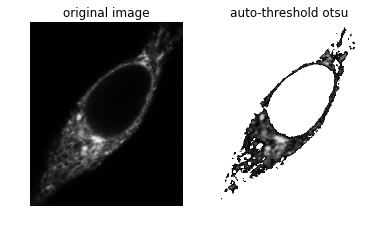

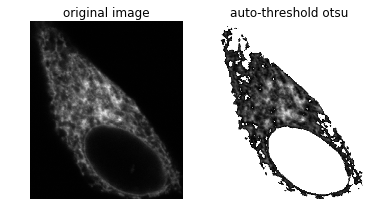

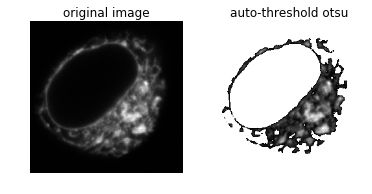

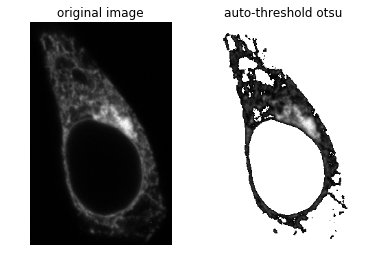

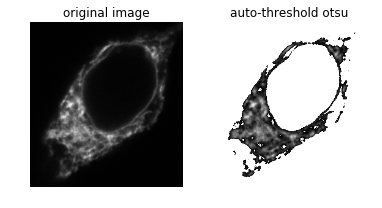

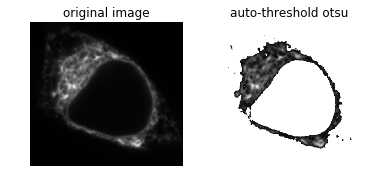

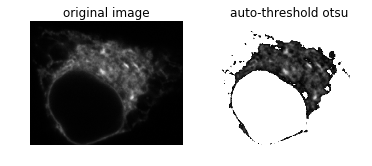

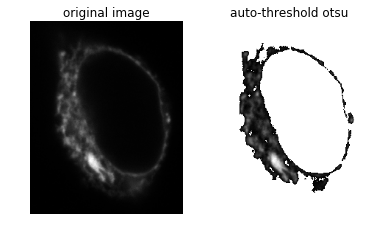

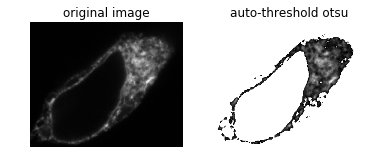

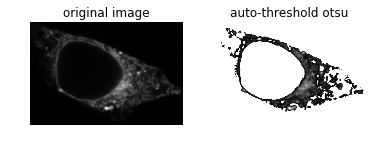

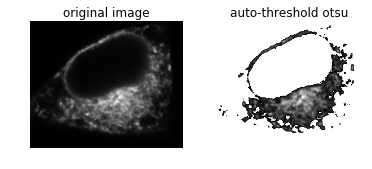

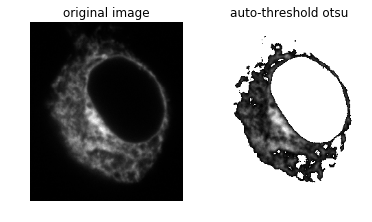

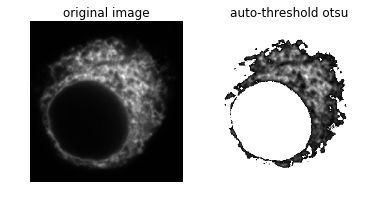

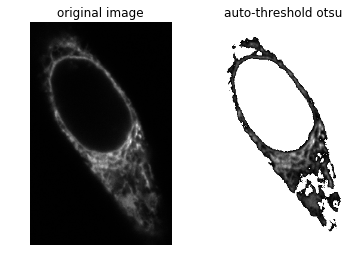

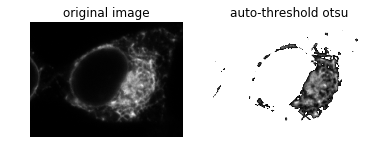

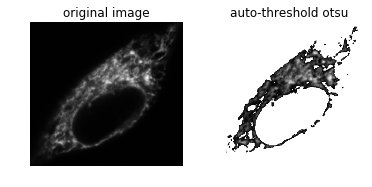

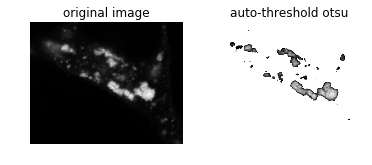

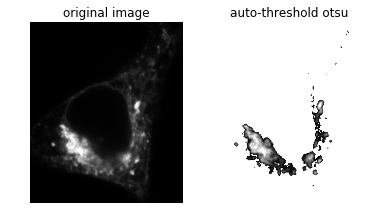

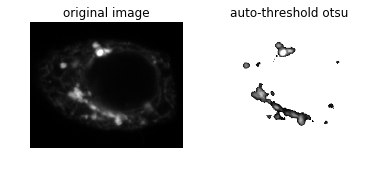

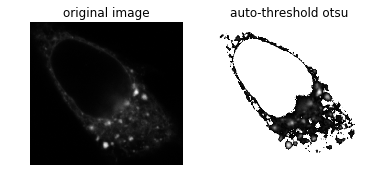

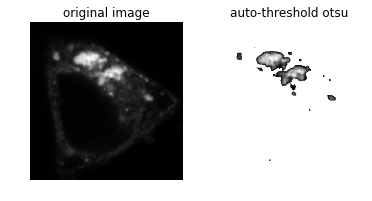

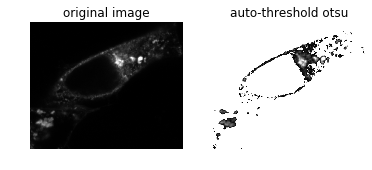

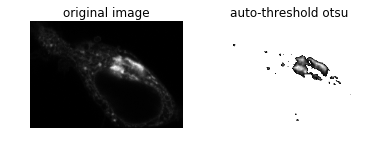

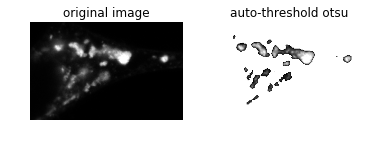

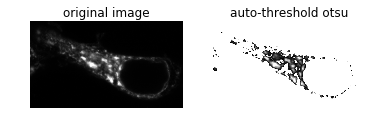

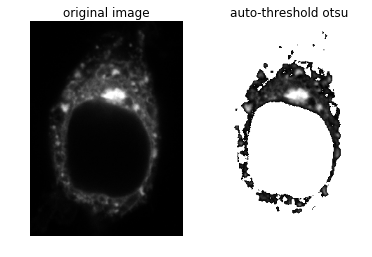

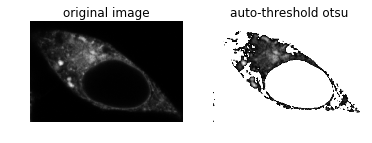

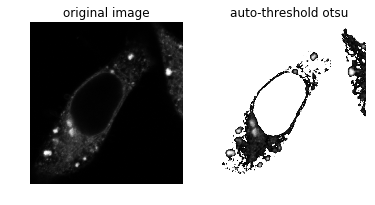

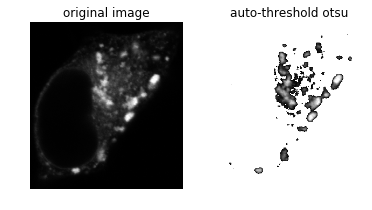

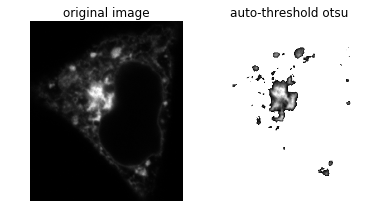

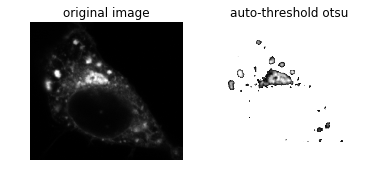

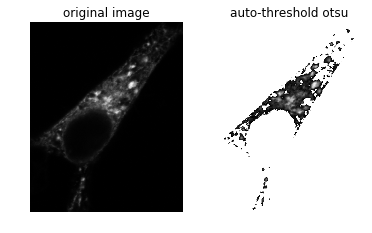

In [12]:
for i in range (0,len(files)):
    image=io.imread(path+files[i])
    #chA=image[100:-100,100:-100,0]
    chA=image[1,:,:]
    figure=plt.figure()
    ax1=plt.subplot(1, 2, 1)
    plt.title("original image")
    plt.imshow(chA,cmap="gray")
    plt.axis("off")
    ax2=plt.subplot(1, 2, 2)
    plt.imshow(np.where(chA*(chA>threshold_otsu(chA-np.min(chA)))==0,np.nan,chA*(chA>threshold_otsu(chA-np.min(chA)))),cmap="gray")
    plt.axis("off")
    plt.title("auto-threshold otsu")


### auto-threshold all images and process with auto-ICS

In [26]:
conditions=["wt","mut"]
pixelsize=82.9 #nm
maxShift=int(30*100/83)
meanImages=[]

allMeanProfiles=[]
allSEMProfiles=[]

corrImageDatasets=[]
for condi in range(0,len(conditions)):
    condiFiles=[file for file in files if conditions[condi] in file]
    
    
    allProfiles=[]
    corrImages=[]
    for i in range (0,len(condiFiles)):
        image=io.imread(path+condiFiles[i])
        chA=image[1,:,:].astype(int)
        chB=image[1,:,:].astype(int)

        bgThresholdA=threshold_otsu(chA-np.min(chA))
        bgThresholdB=threshold_otsu(chB-np.min(chB))
       
        corrImage=xCorr2d(chA,chB,bgThresholdA,bgThresholdB,maxShift)
        corrImages=corrImages+[corrImage]        
        allProfiles+=[radial_profile(corrImage, (len(corrImage)/2,len(corrImage)/2))]

    exportXLS=pd.DataFrame(allProfiles).T
    exportXLS.columns=condiFiles
    exportXLS=pd.concat([pd.DataFrame(exportXLS.index.values*pixelsize,columns=["radius_nm"]),exportXLS],axis=1)
    exportXLS=exportXLS.set_index("radius_nm")
    exportXLS.to_excel(parent+"\\summary_"+conditions[condi]+".xls")
    allMeanProfiles+=[exportXLS.T.mean().values]
    allSEMProfiles+=[exportXLS.T.sem().values]
    meanImages+=[np.mean(corrImages,axis=0)]
    


### plot auto-ICS

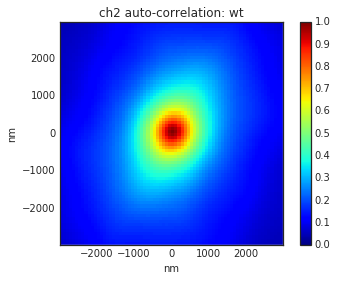

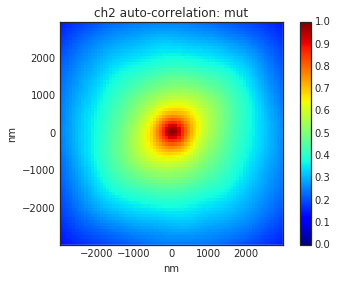

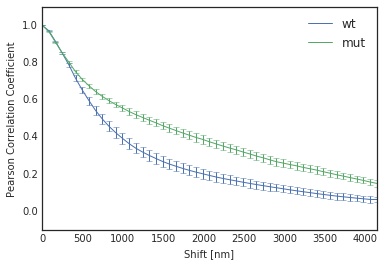

In [27]:

for i in range (0,len(meanImages)):
    dimensions=len(meanImages[i])*pixelsize/2
    fig=plt.figure()
    plt.imshow(meanImages[i],interpolation="none",origin="lower",extent=[-dimensions,dimensions,-dimensions,dimensions],cmap="jet",vmin=0,vmax=1)
    plt.title("ch2 auto-correlation: "+conditions[i])
    plt.xlabel('nm')
    plt.ylabel('nm')
    plt.colorbar()
    plt.savefig(parent+"\\ICS_"+conditions[i]+".png",dpi=300)
    
    
plt.style.use(['seaborn-white', 'seaborn-deep'])
fig=plt.figure()
means=pd.DataFrame(allMeanProfiles).T
sems=pd.DataFrame(allSEMProfiles).T
means.columns=sems.columns=conditions
means.index=means.index=means.index*pixelsize
means.plot(yerr=allSEMProfiles)
plt.ylim(-0.1,1.1)
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Shift [nm]")
plt.savefig(parent+"\\ICS_1D.png",dpi=300)

means.to_excel(parent+"\\summary_allMeans.xls")
sems.to_excel(parent+"\\summary_allSEMs.xls")